# ベジエ曲線による近似の次数による違いを比較

IPython console for SymPy 1.2 (Python 3.6.6-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.2/



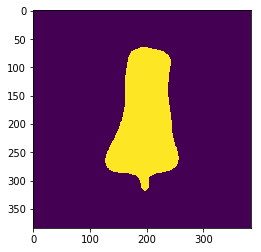

In [1]:
from sympy import *
from sympy.abc import a,b,c
import numpy as np
%matplotlib inline
from sympy import var
from rdlib2 import *
UNIT = 256
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
path='シルエット/17Horn/17aomida1o02_l.jpg'
path='シルエット/17Apically/17daruma6o06_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img)

In [2]:
def threeLinesSeqR2(src, showImage =  False, n_samples=20, N=4, debugmode=False, mode=2): 
    _img,contours,hierarchy = cv2.findContours(src, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
    x0,y0,w,h = cv2.boundingRect(src)
    cnt = contours[0]
    canvas = np.zeros_like(src)
    # 輪郭線の描画
    canvas = cv2.drawContours(canvas, contours, -1, 255, thickness=1)
    # 取り囲む矩形を得る

    # 仮の中心軸を決めるために左右の輪郭のサンプル点を選ぶ
    def getRLlines(): 
        # 上下端それぞれ5％は歪みが大きいので一旦カット   
        cut05 = y0+int(5*h/100) # シルエッ上端から高さ5％の位置
        cut95 = y0+int(95*h/100) # シルエッ下端から高さ95％の位置
        canvas[0:cut05,:]=np.zeros((cut05,src.shape[1]))
        canvas[cut95+1:,:]=np.zeros((src.shape[0]-(cut95+1),src.shape[1]))
    
        # 輪郭検出すれば２つの輪郭が見つかるはず。
        _, contours, hierarchy = cv2.findContours(canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # 線図形の輪郭は中間で折り返しになっている
        cnt0 = contours[0][:int(len(contours[0])/2+1)]
        cnt1 = contours[1][:int(len(contours[1])/2+1)]
        # 中程の点を比べて左にある方を左と判定する。
        c0 = cnt0[int(len(cnt0)/2)][0][0]
        c1 = cnt1[int(len(cnt1)/2)][0][0]
        if  c0 > c1: 
            cntL,cntR = cnt1,cnt0
        else:
            cntR,cntL = cnt1,cnt0
        # print("左輪郭点の数 ", len(cntL),"　右輪郭点の数　", len(cntR))
        cntl = cntL[np.array(list(map(int,np.linspace(0, len(cntL)-1,n_samples))))]
        cntr = cntR[np.array(list(map(int,np.linspace(0, len(cntR)-1,n_samples))))]
        cntl = np.array([[x,y] for [[x,y]] in cntl])
        cntr = np.array([[x,y] for [[x,y]] in cntr])
        return cntl,cntr
    cntl,cntr = getRLlines()

    # 左右をそれぞれベジエ 曲線で近似し、その平均として中心軸を仮決定
    #datal = cpxl,cpyl,bezXl,bezYl,tpl = fitBezierCurveN(cntl,precPara=0.01,N=4,mode=4,debugmode=False)
    datal = cpxl,cpyl,bezXl,bezYl,tpl = fitBezierCurveN(cntl,precPara=0.01,N=N,mode=mode,debugmode=debugmode)
    # precPara=0.01,order=5,mode=5,debugmode=False
    datar = cpxr,cpyr,bezXr,bezYr,tpr = fitBezierCurveN(cntr,precPara=0.01,N=N,mode=mode,debugmode=debugmode)
    bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2

    # 結果の描画
    if showImage:
        tplinsOver = np.linspace(-0.03, 1.03,55)
        tplinsLong = np.linspace(-0.3, 1.3,50)
        tplins50 = np.linspace(0, 1, 50)
        tplins20 = np.linspace(0, 1, 20)
        plt.figure(figsize=(6,6),dpi=100)
        plt.gca().invert_yaxis() 
        plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
        # 左輪郭の描画
        plotx = [bezXl.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYl.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        plt.scatter(cntl[:,0],cntl[:,1],color ='blue',marker = '.') #  サンプル点
        plt.scatter(cpxl,cpyl,color ='purple',marker = '*') #  制御点の描画
        for i in range(N+1):plt.annotate(str(i),(cpxl[i],cpyl[i]))
        # 右輪郭の描画
        plotx = [bezXr.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYr.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        plt.scatter(cntr[:,0],cntr[:,1],color ='blue',marker = '.') #  サンプル点
        plt.scatter(cpxr,cpyr,color ='red',marker = '*') #  制御点の描画
        for i in range(N+1):plt.annotate(str(i),(cpxr[i],cpyr[i]))
        # 中心軸の描画
        plotx = [bezXc.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYc.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        
        plot20lx = [bezXl.subs(t,tp) for tp in tplins20 ]
        plot20ly = [bezYl.subs(t,tp) for tp in tplins20 ]
        plot20cx = [bezXc.subs(t,tp) for tp in tplins20 ]
        plot20cy = [bezYc.subs(t,tp) for tp in tplins20 ]
        plot20rx = [bezXr.subs(t,tp) for tp in tplins20 ]
        plot20ry = [bezYr.subs(t,tp) for tp in tplins20 ]
        
        p0,p1 = symbols('p0,p1')
        bez1 = (1-t)*p0 + t*p1
        
        for x0,x1,y0,y1 in zip(plot20lx,plot20cx,plot20ly,plot20cy):
            fx = bez1.subs([(p0,x0),(p1,x1)])
            fy = bez1.subs([(p0,y0),(p1,y1)])
            plot20x = [fx.subs(t,tp) for tp in tplins20]
            plot20y = [fy.subs(t,tp) for tp in tplins20]
            plt.plot(plot20x,plot20y,color = 'orange') 
        for x0,x1,y0,y1 in zip(plot20rx,plot20cx,plot20ry,plot20cy):
            fx = bez1.subs([(p0,x0),(p1,x1)])
            fy = bez1.subs([(p0,y0),(p1,y1)])
            plot20x = [fx.subs(t,tp) for tp in tplins20]
            plot20y = [fy.subs(t,tp) for tp in tplins20]
            plt.plot(plot20x,plot20y,color = 'orange') 
        
        # plt.scatter(cntr[:,0],cntr[:,1],color ='blue',marker = '.') #     


# 両端固定モード

diffpara 0.10088130086660393
diffpara 0.06499998271465302
diffpara 0.054999954998493195
diffpara 0.04500008933246136
diffpara 0.020000040531158447
diffpara 0.0350000262260437
diffpara 0.0299999862909317
diffpara 0.015000060200691223
diffpara 0.01999998837709427
diffpara 0.004999995231628418
diffpara 0.07543364912271508
diffpara 0.07499998435378075
diffpara 0.050000011920928955
diffpara 0.04500007629394531
diffpara 0.040000058710575104
diffpara 0.02499997615814209
diffpara 0.034999966621398926
diffpara 0.029999978840351105
diffpara 0.020000040531158447
diffpara 0.015000000596046448
diffpara 0.015000000596046448
diffpara 0.009999990463256836


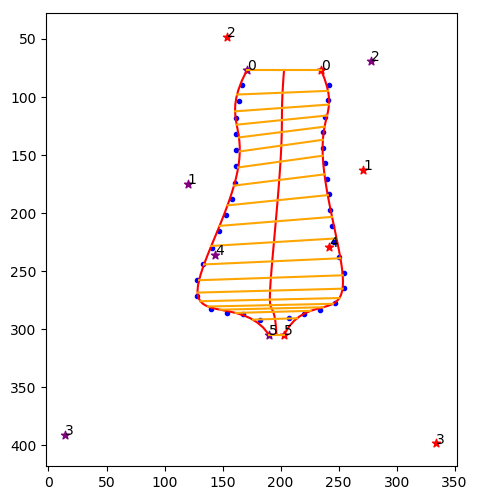

In [3]:
threeLinesSeqR2(img, showImage =  True, n_samples=20,N=5,debugmode=True)

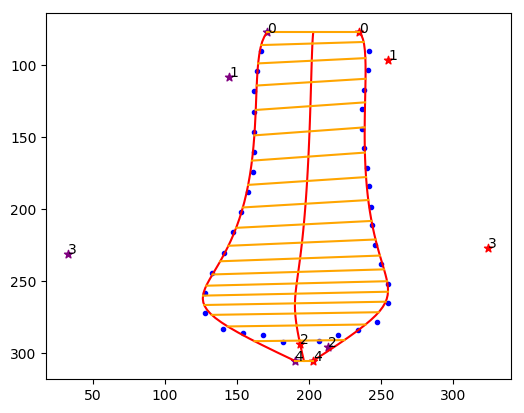

In [4]:
threeLinesSeqR2(img, showImage =  True, n_samples=20,N=4)

# 両端フリーモード

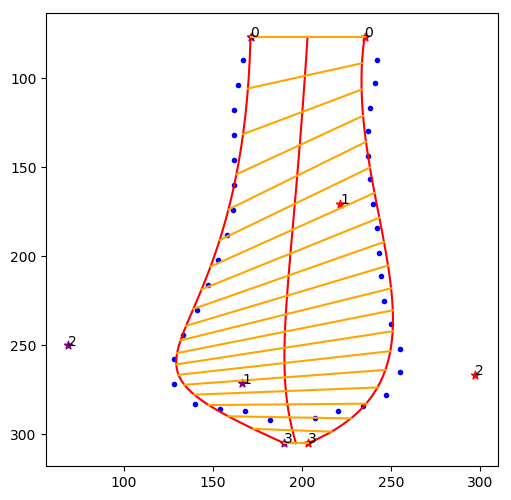

In [5]:
threeLinesSeqR2(img, showImage =  True, n_samples=20,N=3)

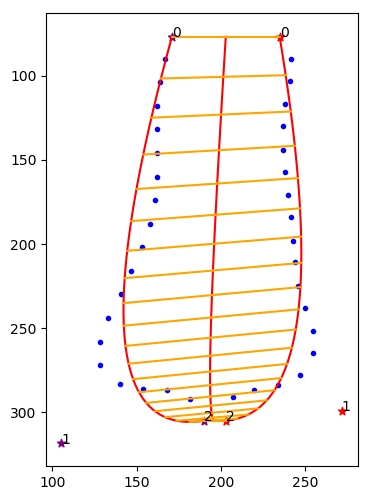

In [6]:
threeLinesSeqR2(img, showImage =  True, n_samples=20,N=2)

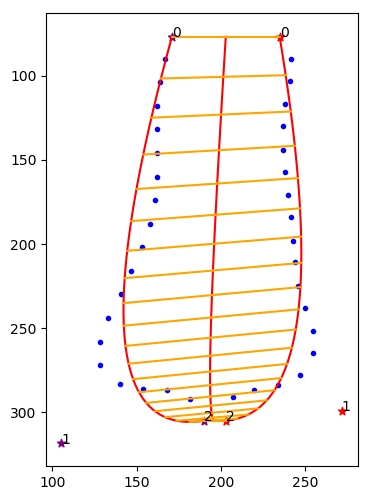

In [7]:
threeLinesSeqR2(img, showImage =  True, n_samples=20,N=2,mode=2)

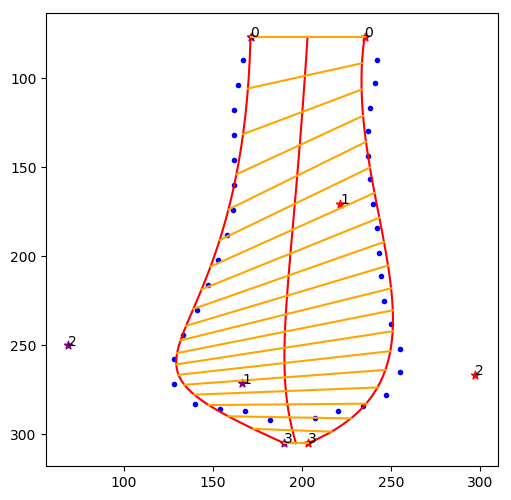

In [8]:
threeLinesSeqR2(img, showImage =  True, n_samples=20,N=3,mode=2)

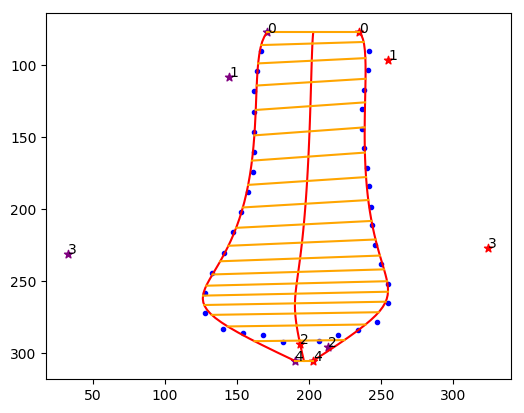

In [9]:
threeLinesSeqR2(img, showImage =  True, n_samples=20,N=4,mode=2)

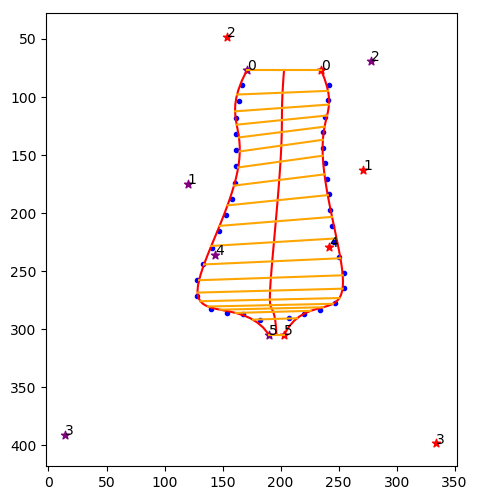

In [10]:
threeLinesSeqR2(img, showImage =  True, n_samples=20,N=5,mode=2)

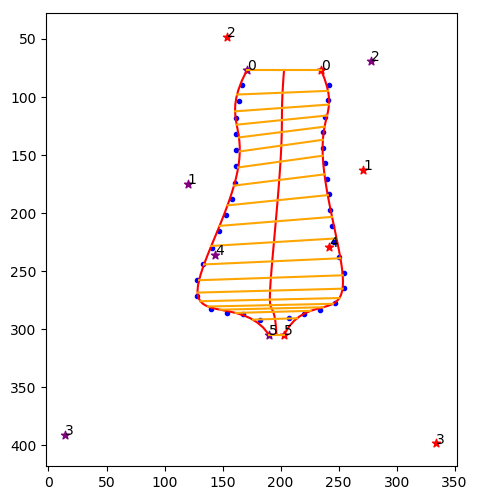

In [11]:
threeLinesSeqR2(img, showImage = True, n_samples=20,N=5,mode=2)

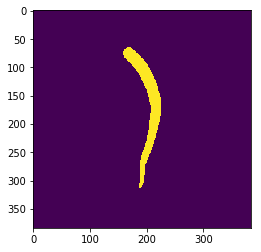

In [12]:
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
path='シルエット/17Apically/17daruma6o06_l.jpg'
path='シルエット/17Horn/17aomida1o02_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img)

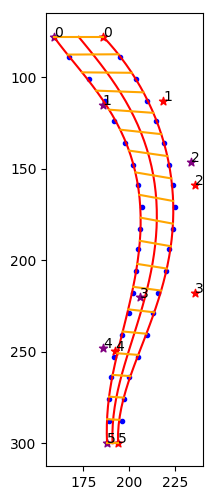

In [13]:
threeLinesSeqR2(img, showImage = True, n_samples=20,N=5,mode=2)

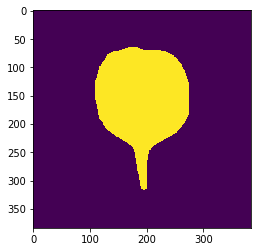

In [14]:
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img)

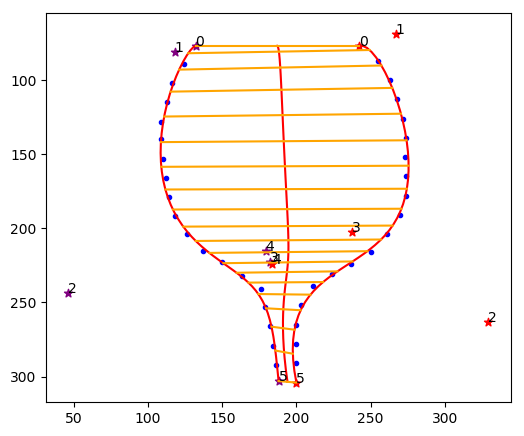

In [15]:
threeLinesSeqR2(img, showImage = True, n_samples=20,N=5,mode=2)

# 第２近似

上で得られた仮の中心軸を基にして上部の斜めにカットされた部分を処理対象に追加した上で処理をやり直す

In [16]:
def threeLinesSeqR3(img, showImage =  False, n_samples=20, N=5, debugmode=False, mode=5): 
    _img,contours,hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
    # バウンダリ矩形を得る
    x0,y0,w,h = cv2.boundingRect(img)
    cnt = contours[0]
    canvas = np.zeros_like(img)
    # 輪郭線の描画
    canvas = cv2.drawContours(canvas, contours, -1, 255, thickness=1)
    # 上下端それぞれ5％は歪みが大きいので一旦カット   
    cut05 = y0+int(5*h/100) # シルエッ上端から高さ5％の位置
    cut95 = y0+int(95*h/100) # シルエッ下端から高さ95％の位置

    # 仮の中心軸を決めるために左右の輪郭の近似記述を得、平均により軸の仮記述とする
    def phase1(): 
        canvas[0:cut05,:]=np.zeros((cut05,img.shape[1]))
        canvas[cut95+1:,:]=np.zeros((img.shape[0]-(cut95+1),img.shape[1]))
    
        # 輪郭検出すれば２つの輪郭が見つかるはず。
        _, contours, hierarchy = cv2.findContours(canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # 線図形の輪郭は中間で折り返しになっている
        cnt0 = contours[0][:int(len(contours[0])/2+1)]
        cnt1 = contours[1][:int(len(contours[1])/2+1)]
        # 中程の点を比べて左にある方を左と判定する。
        c0 = cnt0[int(len(cnt0)/2)][0][0]
        c1 = cnt1[int(len(cnt1)/2)][0][0]
        if  c0 > c1: 
            cntL,cntR = cnt1,cnt0
        else:
            cntR,cntL = cnt1,cnt0
        # print("左輪郭点の数 ", len(cntL),"　右輪郭点の数　", len(cntR))
        cntl = cntL[np.array(list(map(int,np.linspace(0, len(cntL)-1,n_samples))))]
        cntr = cntR[np.array(list(map(int,np.linspace(0, len(cntR)-1,n_samples))))]
        cntl = np.array([[x,y] for [[x,y]] in cntl])
        cntr = np.array([[x,y] for [[x,y]] in cntr])
        
        # 左右をそれぞれベジエ 曲線で近似し、その平均として中心軸を仮決定
        datal = cpxl,cpyl,bezXl,bezYl,tpl = fitBezierCurveN(cntl,precPara=0.01,N=N,mode=mode,debugmode=debugmode)
        # precPara=0.01,order=5,mode=5,debugmode=False
        datar = cpxr,cpyr,bezXr,bezYr,tpr = fitBezierCurveN(cntr,precPara=0.01,N=N,mode=mode,debugmode=debugmode)
        bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2
        ctlc = (cntl+cntr)/2 
        return cntl,cntr,ctlc,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc
    cntl,cntr,ctlc,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc = phase1()
    print('Phase1 finished')
    
        # 結果の描画
    if showImage:
        tplinsOver = np.linspace(-0.03, 1.03,55)
        tplinsLong = np.linspace(-0.3, 1.3,50)
        tplins50 = np.linspace(0, 1, 50)
        tplins20 = np.linspace(0, 1, 20)
        plt.figure(figsize=(6,6),dpi=100)
        plt.gca().invert_yaxis() 
        plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
        # 左輪郭の描画
        plotx = [bezXl.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYl.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        plt.scatter(cntl[:,0],cntl[:,1],color ='blue',marker = '.') #  サンプル点
        # plt.scatter(cpxl,cpyl,color ='purple',marker = '*') #  制御点の描画
        #for i in range(N+1):plt.annotate(str(i),(cpxl[i],cpyl[i]))
        # 右輪郭の描画
        plotx = [bezXr.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYr.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        plt.scatter(cntr[:,0],cntr[:,1],color ='blue',marker = '.') #  サンプル点
        #  plt.scatter(cpxr,cpyr,color ='red',marker = '*') #  制御点の描画
        #for i in range(N+1):plt.annotate(str(i),(cpxr[i],cpyr[i]))
        # 中心軸の描画
        plotx = [bezXc.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYc.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        
        plot20lx = [bezXl.subs(t,tp) for tp in tplins20 ]
        plot20ly = [bezYl.subs(t,tp) for tp in tplins20 ]
        plot20cx = [bezXc.subs(t,tp) for tp in tplins20 ]
        plot20cy = [bezYc.subs(t,tp) for tp in tplins20 ]
        plot20rx = [bezXr.subs(t,tp) for tp in tplins20 ]
        plot20ry = [bezYr.subs(t,tp) for tp in tplins20 ]
        
        p0,p1 = symbols('p0,p1')
        bez1 = (1-t)*p0 + t*p1
        
        for x0,x1,y0,y1 in zip(plot20lx,plot20cx,plot20ly,plot20cy):
            fx = bez1.subs([(p0,x0),(p1,x1)])
            fy = bez1.subs([(p0,y0),(p1,y1)])
            plot20x = [fx.subs(t,tp) for tp in tplins20]
            plot20y = [fy.subs(t,tp) for tp in tplins20]
            plt.plot(plot20x,plot20y,color = 'orange') 
        for x0,x1,y0,y1 in zip(plot20rx,plot20cx,plot20ry,plot20cy):
            fx = bez1.subs([(p0,x0),(p1,x1)])
            fy = bez1.subs([(p0,y0),(p1,y1)])
            plot20x = [fx.subs(t,tp) for tp in tplins20]
            plot20y = [fy.subs(t,tp) for tp in tplins20]
            plt.plot(plot20x,plot20y,color = 'orange') 

    #  得られた仮中心線を基にして輪郭上部をできるだけ軸対称になるよう左右輪郭を取り直す
    def phase2(bezXl,bezYl,bezXr,bezYr,bezXc,bezYc):
        # 得られ左右輪郭のパラメータの一致する点同士を結んだ線分をその位置での仮の幅として仮の最大幅を求める。
        max_width = 0
        max_level = 0
        levels = np.linspace(0, 1, 101)
        for lev in levels:
            xL = bezXl.subs(t,lev)
            yL = bezYl.subs(t,lev)
            xR = bezXr.subs(t,lev)
            yR = bezYr.subs(t,lev)
            w = np.sqrt(float((xL-xR)**2) + float((yL-yR)**2))
            if w > max_width:
                max_width = w
                max_level = lev
        # ループを抜けると最大幅とその時のパラメータ値が得られている。
    
        # 再び輪郭を描く
        _img,contours,hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) #  あらためて輪郭を抽出
        x0,y0,w,h = cv2.boundingRect(img)
        cnt = contours[0]
        canvas = np.zeros_like(img)
        # 輪郭線の描画
        canvas = cv2.drawContours(canvas, contours, -1, 255, thickness=1)
        cntL,cntR = segmentLR(img,cnt,bezXc,bezYc,dmax=max_width,cutRatio=1.3,bottomcutLevel=cut95)
        return cntL,cntR
    cntL,cntR = phase2(bezXl,bezYl,bezXr,bezYr,bezXc,bezYc)
    print('Phase2 finished')
    
    # 再近似
    def phase3(cntl,cntr):
        # 左右をそれぞれ５次のベジエ 曲線で近似し、あらためて中心線と最大幅を得る。
        # リサンプリング
        cntl = cntL[np.array(list(map(int,np.linspace(0, len(cntL)-1,n_samples))))]
        cntr = cntR[np.array(list(map(int,np.linspace(0, len(cntR)-1,n_samples))))] 
        # 再ベジエ 近似
        datal = cpxl,cpyl,bezXl,bezYl,tpl = fitBezierCurveN(cntl,precPara=0.01,N=5,mode=mode,debugmode=True)
        datar = cpxr,cpyr,bezXr,bezYr,tpr = fitBezierCurveN(cntr,precPara=0.01,N=5,mode=mode,debugmode=True)
        bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2
        ctlc = (cntl+cntr)/2 
        # 得られ左右輪郭のパラメータの一致する点同士を結んだ線分をその位置での幅として最大幅を求める。
        max_width = 0
        max_level = 0
        lmaxP,rmaxP = np.array([0,0]),np.array([0,0])
        levels = np.linspace(0, 1, 101)
        for lev in levels:
            xL = bezXl.subs(t,lev)
            yL = bezYl.subs(t,lev)
            xR = bezXr.subs(t,lev)
            yR = bezYr.subs(t,lev)
            w = np.sqrt(float((xL-xR)**2) + float((yL-yR)**2))
            if w > max_width:
                max_width = w
                max_level = lev
                lmaxP,rmaxP = np.array([xL,yL]),np.array([xR,yR])
        # ループを抜けると最大幅とその時のパラメータ値が得られている。
        return cntl,cntr,cpxl,cpyl,cpxr,cpyr,bezXl,bezYl,bezXr,bezYr
    cntl,cntr,cpxl,cpyl,cpxr,cpyr,bezXl,bezYl,bezXr,bezYr = phase3(cntl = cntL,cntr = cntR)
    bezXc = (bezXl+bezXr)/2
    bezYc = (bezYl+bezYr)/2
    print('Phase3 finished')
    
    # 中心軸に等間隔にサンプル点を取り（２０個）、その点での法線の方程式に輪郭のベジエ 表現式を代入して５次方程式を解き、
    # 法線と左右の輪郭の交点を求める。
    def phase4(bezXc,bezYc,bezXr,bezYr,bezXl,bezYl):
        PlistL,PlistR = [],[]
        for i in np.linspace(0, 1, 20):
            y0 = bezYc.subs(t,i)
            x0 = bezXc.subs(t,i)
            dx = diff(bezXc,t).subs(t,i) # x、y をそれぞれ t で微分　傾きを求めようとしている
            dy = diff(bezYc,t).subs(t,i)
            ans = solve(-dx/dy*(bezXr-x0)+y0-bezYr,t) # 法線とベジエ輪郭の交点を求める
            s = [i for i in ans if im(i)==0 and i<=1 and 0<=i]
            PlistR.append(s)
        for i in np.linspace(0, 1, 20):
            y0 = bezYc.subs(t,i)
            x0 = bezXc.subs(t,i)
            dx = diff(bezXc,t).subs(t,i) # x、y をそれぞれ t で微分　傾きを求めようとしている
            dy = diff(bezYc,t).subs(t,i)
            ans = solve(-dx/dy*(bezXl-x0)+y0-bezYl,t) # 法線とベジエ輪郭の交点を求める
            s = [i for i in ans if im(i)==0 and i<=1 and 0<=i]
            PlistL.append(s)

        
        # 定積分により軸に沿った長さを求める
        '''dxdt = diff(bezXc,t)
        dydt = diff(bezYc,t)
        leng = integrate(sqrt(dxdt**2+dydt**2),(t,0,s))
        radiusTable = []
        for i, tpara in enumerate(np.linspace(0,1,20)):
            print(PlistL,PlistR)
            len = float(leng.subs(s,tpara)) # 上端からの長さ
            if PlistL[i] != [] and PlistR[i] != []:
                radishR = float((PlistL[i][0]+PlistR[i][0])/2) # 太さ
                radiusTable.append([len,radishR]) 
            else:
                radiusTable.append([len,np.inf]) '''
        
        #結果の描画
        if True:
            tplins50 = np.linspace(0, 1, 50)
            tplins20 = np.linspace(0, 1, 20)
            plt.figure(figsize=(6,6),dpi=100)
            plt.gca().invert_yaxis() 
            plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
            plt.imshow(192+(cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)/4).astype(np.uint8))

            # 左輪郭の描画
            plotx = [bezXl.subs(t,tp) for tp in tplins50 ]
            ploty = [bezYl.subs(t,tp) for tp in tplins50 ]
            plt.plot(plotx,ploty,color = 'red')  
            # plt.scatter(cntl[:,0],cntl[:,1],color ='blue',marker = '.') #  サンプル点
            plt.scatter(cpxl,cpyl,color ='purple',marker = '*') #  制御点の描画
            for i in range(N+1):plt.annotate(str(i),(cpxl[i],cpyl[i]))

            # 右輪郭の描画
            plotx = [bezXr.subs(t,tp) for tp in tplins50 ]
            ploty = [bezYr.subs(t,tp) for tp in tplins50 ]
            plt.plot(plotx,ploty,color = 'red')  
            #plt.scatter(cntr[:,0],cntr[:,1],color ='blue',marker = '.') #  サンプル点
            plt.scatter(cpxr,cpyr,color ='red',marker = '*') #  制御点の描画
            for i in range(N+1):plt.annotate(str(i),(cpxr[i],cpyr[i]))
            # 中心軸の描画
            plotx = [bezXc.subs(t,tp) for tp in tplins50 ]
            ploty = [bezYc.subs(t,tp) for tp in tplins50 ]
            plt.plot(plotx,ploty,color = 'red')  
        
            # 幅線の描画
            plot20lx = [bezXl.subs(t,tp[0]) if tp !=[] else [] for tp in PlistL ]
            plot20ly = [bezYl.subs(t,tp[0]) if tp !=[] else [] for tp in PlistL]
            plot20cx = [bezXc.subs(t,tp) for tp in np.linspace(0, 1, 20) ]
            plot20cy = [bezYc.subs(t,tp) for tp in np.linspace(0, 1, 20) ]
            plot20rx = [bezXr.subs(t,tp[0]) if tp !=[] else [] for tp in PlistR ]
            plot20ry = [bezYr.subs(t,tp[0]) if tp !=[] else [] for tp in PlistR ]
        
            # 内分点の定義式（１次のベジエ ）
            p0,p1 = symbols('p0,p1')
            bez1 = (1-t)*p0 + t*p1
        
            for x0,x1,y0,y1 in zip(plot20lx,plot20cx,plot20ly,plot20cy):
                if x0 != [] and y0 !=[]:
                    fx = bez1.subs([(p0,x0),(p1,x1)])
                    fy = bez1.subs([(p0,y0),(p1,y1)])
                    plot20x = [fx.subs(t,tp) for tp in tplins20]
                    plot20y = [fy.subs(t,tp) for tp in tplins20]
                    plt.plot(plot20x,plot20y,color = 'orange') 
            for x0,x1,y0,y1 in zip(plot20rx,plot20cx,plot20ry,plot20cy):
                if x0 != [] and y0 !=[]:
                    fx = bez1.subs([(p0,x0),(p1,x1)])
                    fy = bez1.subs([(p0,y0),(p1,y1)])
                    plot20x = [fx.subs(t,tp) for tp in tplins20]
                    plot20y = [fy.subs(t,tp) for tp in tplins20]
                    plt.plot(plot20x,plot20y,color = 'orange') 
    
        return 0 # radiusTable
    radiusTable = phase4(bezXc,bezYc,bezXr,bezYr,bezXl,bezYl)
    print('Phase4 finished')
        
    return cntl,cntr,cpxl,cpyl,cpxr,cpyr,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc #,radiusTable
            
# 中心軸情報をもとに輪郭データを左右に分ける
def segmentLR(img,cnt,bezX,bezY,dmax,cutRatio=2,bottomcutLevel = 10):
    # あらためて概形画像から輪郭線を抽出
    #  img 画像 サイズの参照だけ
    # bezX,bezY 中心軸近似ベジエ曲線
    # dmax 最大直径
    # tcutRatio上部を削るために描く円の半径に掛ける倍率
    # bottomcutRadius　下部を削るために描く円の半径
    
    # 輪郭線の描画
    canvas = np.zeros_like(img)
    canvas = cv2.drawContours(canvas, cnt, -1, 255, thickness=1)
    # 中心軸の延長で上端から最大半径離れた地点を中心に最大半径より少し大きな円を０で描き輪郭を削る。
    dx = float(diff(bezX,t).subs(t,0.1)) # t=0 は境界なので変な値にあることがあるため 0.08 としている
    dy = float(diff(bezY,t).subs(t,0.1))
    acc = dy/dx if dx != 0 else np.inf
    nom = -dx/dy if dy != 0 else np.inf
    x00 = bezX.subs(t,0) #  軸の再上端
    y00 = bezY.subs(t,0)
    print(x00,y00,dx,dy,acc) 
    if acc == 0:
        if bezX.subs(s,1) > x00:
            xdd = dmax/2
        else:
            xdd = -dmax/2
    else:
        xdd = -dmax/2/acc
    x11 = x00+xdd 
    y11 = y00+xdd*acc if acc != 0 else y00
    y11 = y00-dmax/2 if dx*dx < 0.0001 else y11
    dia = int(dmax/2*cutRatio) # int(np.sqrt(float((x00-x11)**2+(y00-y11)**2)))
    canvas =  cv2.circle(canvas,(int(x11),int(y11)),dia,0,-1)
    # 下端を削る
    canvas[bottomcutLevel+1:,:]=np.zeros((img.shape[0]-(bottomcutLevel+1),img.shape[1])) 
        
    plt.figure(figsize=(6,6),dpi=100)    
    plt.imshow(canvas)
    
    # 輪郭検出すれば２つの輪郭が見つかるはず。
    _, contours, hierarchy = cv2.findContours(canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 線図形の輪郭は中間で折り返しになっている
    cnt0 = contours[0][:int(len(contours[0])/2+1)]
    cnt1 = contours[1][:int(len(contours[1])/2+1)]
    # 中程の点を比べて左にある方を左と判定する。
    c0 = cnt0[int(len(cnt0)/2)][0][0]
    c1 = cnt1[int(len(cnt1)/2)][0][0]
    if  c0 > c1: 
        cntL,cntR = cnt1,cnt0
    else:
        cntR,cntL = cnt1,cnt0
    print("左輪郭点の数 ", len(cntL),"　右輪郭点の数　", len(cntR))
    #  ２重かっこを１重に変換し、numpy array にしてから返す
    cntL = np.array([[x,y] for [[x,y]] in cntL])
    cntR = np.array([[x,y] for [[x,y]] in cntR])                
    return cntL,cntR

diffpara 0.10088130086660393
diffpara 0.06499998271465302
diffpara 0.054999954998493195
diffpara 0.04500008933246136
diffpara 0.020000040531158447
diffpara 0.0350000262260437
diffpara 0.0299999862909317
diffpara 0.015000060200691223
diffpara 0.01999998837709427
diffpara 0.004999995231628418
diffpara 0.07543364912271508
diffpara 0.07499998435378075
diffpara 0.050000011920928955
diffpara 0.04500007629394531
diffpara 0.040000058710575104
diffpara 0.02499997615814209
diffpara 0.034999966621398926
diffpara 0.029999978840351105
diffpara 0.020000040531158447
diffpara 0.015000000596046448
diffpara 0.015000000596046448
diffpara 0.009999990463256836
Phase1 finished
203 77 -4.47628730469094 219.6516498172605 -49.070051778641606
左輪郭点の数  211 　右輪郭点の数　 199
Phase2 finished
diffpara 0.1468825489282609
diffpara 0.02499997615814209
diffpara 0.03000001609325409
diffpara 0.02499997615814209
diffpara 0.004999995231628418
diffpara 0.09479037672281274
diffpara 0.03999999165534973
diffpara 0.04000000283122063


ValueError: not enough values to unpack (expected 13, got 12)

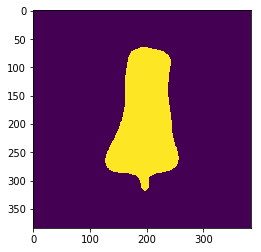

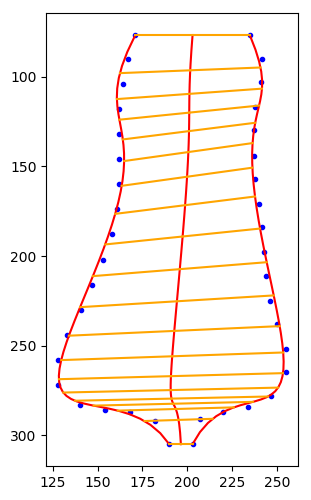

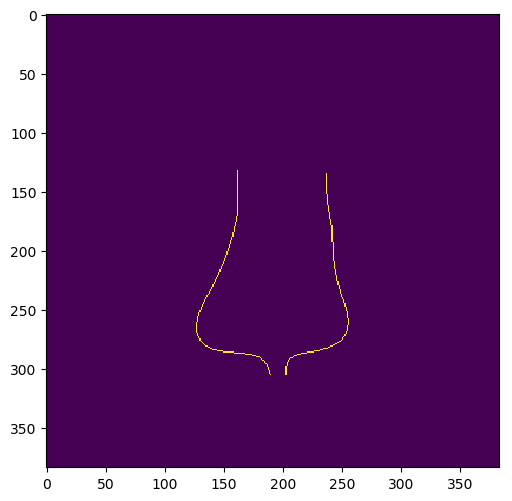

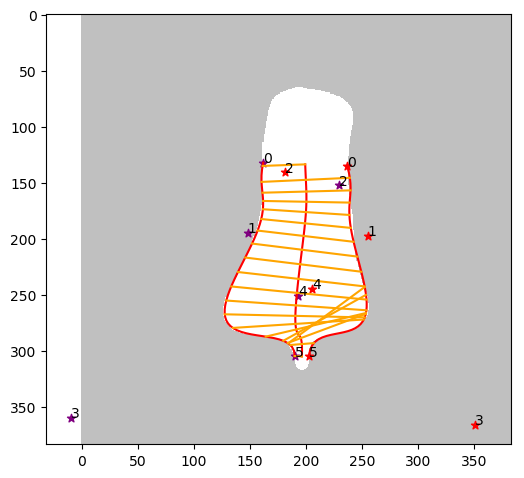

In [17]:
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
path='シルエット/17Horn/17aomida1o02_l.jpg'
path='シルエット/17Apically/17daruma6o06_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img)
# cntl,cntr,cpxl,cpyl,cpxr,cpyr,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc,radiusTable = threeLinesSeqR3(img, showImage = True, n_samples=20, N=5, debugmode=True, mode=2)

cntl,cntr,cpxl,cpyl,cpxr,cpyr,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc= threeLinesSeqR3(img, showImage = True, n_samples=20, N=5, debugmode=True, mode=2)

In [ ]:
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
path='シルエット/17Horn/17aomida1o02_l.jpg'
path='シルエット/17Apically/17daruma6o06_l.jpg'
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img)
# cntl,cntr,cpxl,cpyl,cpxr,cpyr,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc,radiusTable = threeLinesSeqR3(img, showImage = True, n_samples=20, N=5, debugmode=True, mode=2)
cntl,cntr,cpxl,cpyl,cpxr,cpyr,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc = threeLinesSeqR3(img, showImage = True, n_samples=20, N=5, debugmode=True, mode=2)

In [ ]:
path='シルエット/17Horn/17aomida1o02_l.jpg'
path='シルエット/17Apically/17daruma6o06_l.jpg'
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img)
# cntl,cntr,cpxl,cpyl,cpxr,cpyr,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc,radiusTable = threeLinesSeqR3(img, showImage = True, n_samples=20, N=5, debugmode=True, mode=2)
cntl,cntr,cpxl,cpyl,cpxr,cpyr,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc = threeLinesSeqR3(img, showImage = True, n_samples=20, N=5, debugmode=True, mode=2)

# 中心軸の法線と輪郭の交点

４次や５次のベジエ曲線と直線の交点は可能性としては４つ、５つの解があり得るので解くのは困難かと思われたが、sympy の solve で意外とあっさりとける。もちろん解は虚部を持つものを入れると５次なら５つ出てくるが、０〜１の範囲の実解という制約条件を満たすものは、複雑な曲がりがない限りは１つしかないので、ほとんどの場合において、制約を満たす解は１つである。

In [ ]:
path='シルエット/17Cylindric/17kohaku1o09_l.jpg'
path ='シルエット/17Spheric/17yakumi2o06_l.jpg'
path='シルエット/17Apically/17daruma6o06_l.jpg'
path='シルエット/17Horn/17aomida1o02_l.jpg'
src = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = getstandardShape(src, unitSize=UNIT,showResult=False)  
plt.imshow(img)
cntl,cntr,cpxl,cpyl,cpxr,cpyr,bezXl,bezYl,bezXr,bezYr,bezXc,bezYc = threeLinesSeqR3(img, showImage = True, n_samples=20, N=5, debugmode=True, mode=2)

In [ ]:
PlistL,PlistR = [],[]
for i in np.linspace(0, 1, 20):
    y0 = bezYc.subs(t,i)
    x0 = bezXc.subs(t,i)
    dx = diff(bezXc,t).subs(t,i)
    dy = diff(bezYc,t).subs(t,i)
    ans = solve(-dx/dy*(bezXr-x0)+y0-bezYr,t)
    s = [i for i in ans if im(i)==0 and i<=1.2 and -0.2<=i]
    PlistR.append(s)
for i in np.linspace(0, 1, 20):
    y0 = bezYc.subs(t,i)
    x0 = bezXc.subs(t,i)
    dx = diff(bezXc,t).subs(t,i)
    dy = diff(bezYc,t).subs(t,i)
    ans = solve(-dx/dy*(bezXl-x0)+y0-bezYl,t)
    s = [i for i in ans if im(i)==0 and i<=1.2 and -0.2<=i]
    PlistL.append(s)
    # 結果の描画
N=5
if True:
        tplins50 = np.linspace(0, 1, 50)
        tplins20 = np.linspace(0, 1, 20)
        plt.figure(figsize=(6,6),dpi=100)
        plt.gca().invert_yaxis() 
        plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
        # 左輪郭の描画
        plotx = [bezXl.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYl.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        plt.scatter(cntl[:,0],cntl[:,1],color ='blue',marker = '.') #  サンプル点
        plt.scatter(cpxl,cpyl,color ='purple',marker = '*') #  制御点の描画
        for i in range(N+1):plt.annotate(str(i),(cpxl[i],cpyl[i]))
        # 右輪郭の描画
        plotx = [bezXr.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYr.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        plt.scatter(cntr[:,0],cntr[:,1],color ='blue',marker = '.') #  サンプル点
        plt.scatter(cpxr,cpyr,color ='red',marker = '*') #  制御点の描画
        for i in range(N+1):plt.annotate(str(i),(cpxr[i],cpyr[i]))
        # 中心軸の描画
        plotx = [bezXc.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYc.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        
        plot20lx = [bezXl.subs(t,tp[0]) if tp !=[] else [] for tp in PlistL ]
        plot20ly = [bezYl.subs(t,tp[0]) if tp !=[] else [] for tp in PlistL]
        plot20cx = [bezXc.subs(t,tp) for tp in np.linspace(0, 1, 20) ]
        plot20cy = [bezYc.subs(t,tp) for tp in np.linspace(0, 1, 20) ]
        plot20rx = [bezXr.subs(t,tp[0]) if tp !=[] else [] for tp in PlistR ]
        plot20ry = [bezYr.subs(t,tp[0]) if tp !=[] else [] for tp in PlistR ]
        
        p0,p1 = symbols('p0,p1')
        bez1 = (1-t)*p0 + t*p1
        
        for x0,x1,y0,y1 in zip(plot20lx,plot20cx,plot20ly,plot20cy):
            if x0 != [] and y0 !=[]:
                fx = bez1.subs([(p0,x0),(p1,x1)])
                fy = bez1.subs([(p0,y0),(p1,y1)])
                plot20x = [fx.subs(t,tp) for tp in tplins20]
                plot20y = [fy.subs(t,tp) for tp in tplins20]
                plt.plot(plot20x,plot20y,color = 'orange') 
        for x0,x1,y0,y1 in zip(plot20rx,plot20cx,plot20ry,plot20cy):
            if x0 != [] and y0 !=[]:
                fx = bez1.subs([(p0,x0),(p1,x1)])
                fy = bez1.subs([(p0,y0),(p1,y1)])
                plot20x = [fx.subs(t,tp) for tp in tplins20]
                plot20y = [fy.subs(t,tp) for tp in tplins20]
                plt.plot(plot20x,plot20y,color = 'orange') 